# ☀️ Solar Radiation Data Analysis — Benin 🇧🇯


In [17]:
#all imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
sys.path.append('../scripts')
import warnings
from scipy.stats import zscore
from data_quality_utils import columns_with_significant_missing_values,detect_outliers_zscore

In [2]:
#suppress all warnings
warnings.filterwarnings("ignore")

## 📊 1. Introduction & Objective

### Background in the Subject Matter

Understanding lead and lag measures is crucial in solar energy analytics to identify what drives performance (lead) and what reflects performance outcomes (lag).

---

#### 🔹 Lead Measures

| Parameter         | Description |
|------------------|-------------|
| **Cleaning (1/0)** | Indicates whether a cleaning event occurred. A direct action that can influence panel efficiency. |
| **Precipitation (mm/min)** | Natural cleaning mechanism. Affects panel cleanliness and performance. |
| **RH (Relative Humidity)** | Can contribute to soiling or panel fogging. A predictive factor for efficiency. |
| **WS (Wind Speed)** | Can help remove dust/debris. High wind may act as a natural cleaning factor. |
| **TModA / TModB (°C)** | Module temperatures. Impact the conversion efficiency — monitored to optimize performance. |



#### 🔹 Lag Measures

| Parameter         | Description |
|------------------|-------------|
| **GHI (Global Horizontal Irradiance)** | Total solar radiation on a horizontal surface — reflects solar availability. |
| **DNI (Direct Normal Irradiance)** | Direct solar radiation received perpendicularly — outcome of atmospheric conditions. |
| **DHI (Diffuse Horizontal Irradiance)** | Scattered sunlight received — indicates sky clarity. |
| **ModA / ModB (W/m²)** | Actual power received by panels — outcome of environmental and maintenance factors. |
| **Tamb (Ambient Temperature)** | Environmental factor — affects efficiency but cannot be controlled. |
| **BP (Barometric Pressure)** | Reflects atmospheric conditions — no direct control. |
| **WD / WDstdev** | Wind direction and its variability — background environmental effects. |
| **WSstdev / WSgust** | Wind variability and gusts — lag indicators of natural impacts. |



### 🎯 Business Objective

Perform a quick yet insightful analysis of solar radiation and environmental data to:
- Identify **key trends and performance drivers**.
- Understand the **impact of environmental conditions** on solar energy potential.
- Evaluate the **effect of soiling and cleaning** on solar module performance.
- Recommend **ideal conditions or locations** for sustainable solar installations.


### 🧠 Key Questions to Explore

1. **Solar Potential**  
   - Where and when is solar radiation (`GHI`, `DNI`, `DHI`) strongest and most consistent?

2. **Environmental Impact on Performance**  
   - How do temperature, humidity, wind, and pressure affect solar metrics?

3. **Sensor/Module Performance**  
   - How do `ModA` and `ModB` correlate with irradiance data?
   - Are performance improvements observed after cleaning?

4. **Cleaning Effectiveness**  
   - What is the impact of cleaning events on solar performance?
   - Can a cleaning schedule be recommended?

## 📦 2. Data Loading & Overview

#### Loading Data

In [3]:
#load the data from the github repo or #using locally stored dataset
df=pd.read_csv('../data/benin-malanville.csv')
df

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525595,2022-08-08 23:56,-5.5,-0.1,-5.9,0.0,0.0,23.1,98.3,0.3,1.1,0.5,119.3,4.1,996,0,0.0,23.5,22.9,NaN
525596,2022-08-08 23:57,-5.5,-0.1,-5.8,0.0,0.0,23.1,98.3,0.2,0.7,0.4,115.2,2.3,996,0,0.0,23.5,22.9,NaN
525597,2022-08-08 23:58,-5.5,-0.1,-5.8,0.0,0.0,23.1,98.4,0.6,1.1,0.5,129.8,3.4,996,0,0.0,23.5,22.9,NaN
525598,2022-08-08 23:59,-5.5,-0.1,-5.8,0.0,0.0,23.1,98.3,0.9,1.3,0.5,124.4,4.3,996,0,0.0,23.5,22.9,NaN


#### Data Overview

In [4]:
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


In [5]:
df.tail()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
525595,2022-08-08 23:56,-5.5,-0.1,-5.9,0.0,0.0,23.1,98.3,0.3,1.1,0.5,119.3,4.1,996,0,0.0,23.5,22.9,NaN
525596,2022-08-08 23:57,-5.5,-0.1,-5.8,0.0,0.0,23.1,98.3,0.2,0.7,0.4,115.2,2.3,996,0,0.0,23.5,22.9,NaN
525597,2022-08-08 23:58,-5.5,-0.1,-5.8,0.0,0.0,23.1,98.4,0.6,1.1,0.5,129.8,3.4,996,0,0.0,23.5,22.9,NaN
525598,2022-08-08 23:59,-5.5,-0.1,-5.8,0.0,0.0,23.1,98.3,0.9,1.3,0.5,124.4,4.3,996,0,0.0,23.5,22.9,NaN
525599,2022-08-09 00:00,-5.5,-0.1,-5.7,0.0,0.0,23.1,98.3,1.2,1.6,0.3,124.1,5.9,996,0,0.0,23.5,22.9,NaN


In [6]:
df.sample(10)

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
462712,2022-06-26 07:53,165.7,52.0,147.1,134.3,133.4,26.1,81.9,2.4,3.1,0.5,220.1,10.4,996,0,0.0,33.0,30.3,NaN
241162,2022-01-23 11:23,834.0,886.8,139.0,913.4,859.0,26.8,14.9,6.4,8.7,1.3,73.5,14.1,999,0,0.0,45.9,35.5,NaN
42276,2021-09-07 08:37,-1.2,-0.1,-0.2,2.7,2.7,22.6,90.0,8.2,10.2,1.1,125.2,7.7,999,0,0.0,22.9,22.3,NaN
353129,2022-04-11 05:30,-1.5,-0.4,-1.7,0.0,0.0,30.9,51.7,3.5,4.1,0.5,228.0,10.1,989,0,0.0,30.5,29.9,NaN
215695,2022-01-05 18:56,-7.9,-0.8,-10.2,0.1,0.1,27.1,33.1,1.3,1.6,0.4,342.9,4.4,995,0,0.0,25.6,24.8,NaN
408476,2022-05-19 15:57,593.1,404.9,308.8,499.2,485.7,39.6,31.4,2.0,2.9,0.6,138.2,8.0,990,0,0.0,50.6,54.0,NaN
346534,2022-04-06 15:35,540.3,226.1,358.7,505.2,489.9,42.0,17.0,4.1,5.1,0.7,103.1,9.7,988,0,0.0,53.0,49.0,NaN
185949,2021-12-16 03:10,-3.2,-0.2,-5.3,0.0,0.0,19.4,33.2,1.9,2.4,0.3,47.0,5.5,995,0,0.0,16.3,16.1,NaN
86247,2021-10-07 21:28,-2.0,-0.4,-2.0,0.0,0.0,28.4,79.5,2.0,2.4,0.3,180.1,3.3,994,0,0.0,27.3,26.7,NaN
154141,2021-11-24 01:02,-1.3,-0.6,-1.4,0.0,0.0,21.1,68.0,0.8,1.6,0.6,319.9,7.1,995,0,0.0,19.1,18.2,NaN


In [7]:
#shape of the dataset
df.shape

(525600, 19)

In [8]:
#list of columns of the dataset
df.columns

Index(['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS',
       'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation',
       'TModA', 'TModB', 'Comments'],
      dtype='object')

## 📐 3. Data Types & Basic Stats

#### Data Summaries - basics stats

In [9]:
#Numerical Columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
GHI,525600.0,240.559452,331.131327,-12.9,-2.0,1.8,483.4,1413.0
DNI,525600.0,167.187516,261.710501,-7.8,-0.5,-0.1,314.2,952.3
DHI,525600.0,115.358961,158.691074,-12.6,-2.1,1.6,216.3,759.2
ModA,525600.0,236.589496,326.894859,0.0,0.0,4.5,463.7,1342.3
ModB,525600.0,228.883576,316.536515,0.0,0.0,4.3,447.9,1342.3
Tamb,525600.0,28.179683,5.924297,11.0,24.2,28.0,32.3,43.8
RH,525600.0,54.487969,28.073069,2.1,28.8,55.1,80.1,100.0
WS,525600.0,2.121113,1.603466,0.0,1.0,1.9,3.1,19.5
WSgust,525600.0,2.809195,2.029120,0.0,1.3,2.6,4.1,26.6
WSstdev,525600.0,0.473390,0.273395,0.0,0.4,0.5,0.6,4.2


In [10]:
#for columns of object type
df.describe(include=['O']).T

,count,unique,top,freq
Timestamp,525600,525600,2022-08-08 23:44,1


#### Data Types

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600 non-null  float64
 17  TModB          525600 non-nul

## 🔍 4. Data Quality Analysis

### Missing-Values Analysis

In [12]:
#count of missing values per column
df.isna().sum() 

Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

##### Columns with significant number of missing values

In [13]:
#column with >5% nulls
columns_with_significant_missing_values(df, threshold=5)

,#missing_values,percentage
Comments,525600,100.00%


### Duplicated Values Analysis

In [14]:
#check for duplicates
print(df.duplicated().sum())

0


### Outlier Detection

#### Detect outliers

In [15]:
#checking for outliers in select columns
#using z-score method
columns_to_check_for_outliers = ['ModA','ModB','WS','WSgust','GHI','DHI','DNI']
outlier_counts = {
    "column": [],
    "num_outliers": []
}

for col in columns_to_check_for_outliers:
    outliers = detect_outliers_zscore(df, col)
    outlier_counts["column"].append(col)
    outlier_counts["num_outliers"].append(len(outliers))

outlier_df = pd.DataFrame(outlier_counts)
print(outlier_df)
    

   column  num_outliers
0    ModA            27
1    ModB            63
2      WS          3109
3  WSgust          3500
4     GHI            89
5     DHI          3738
6     DNI             0


#### Visualize outliers

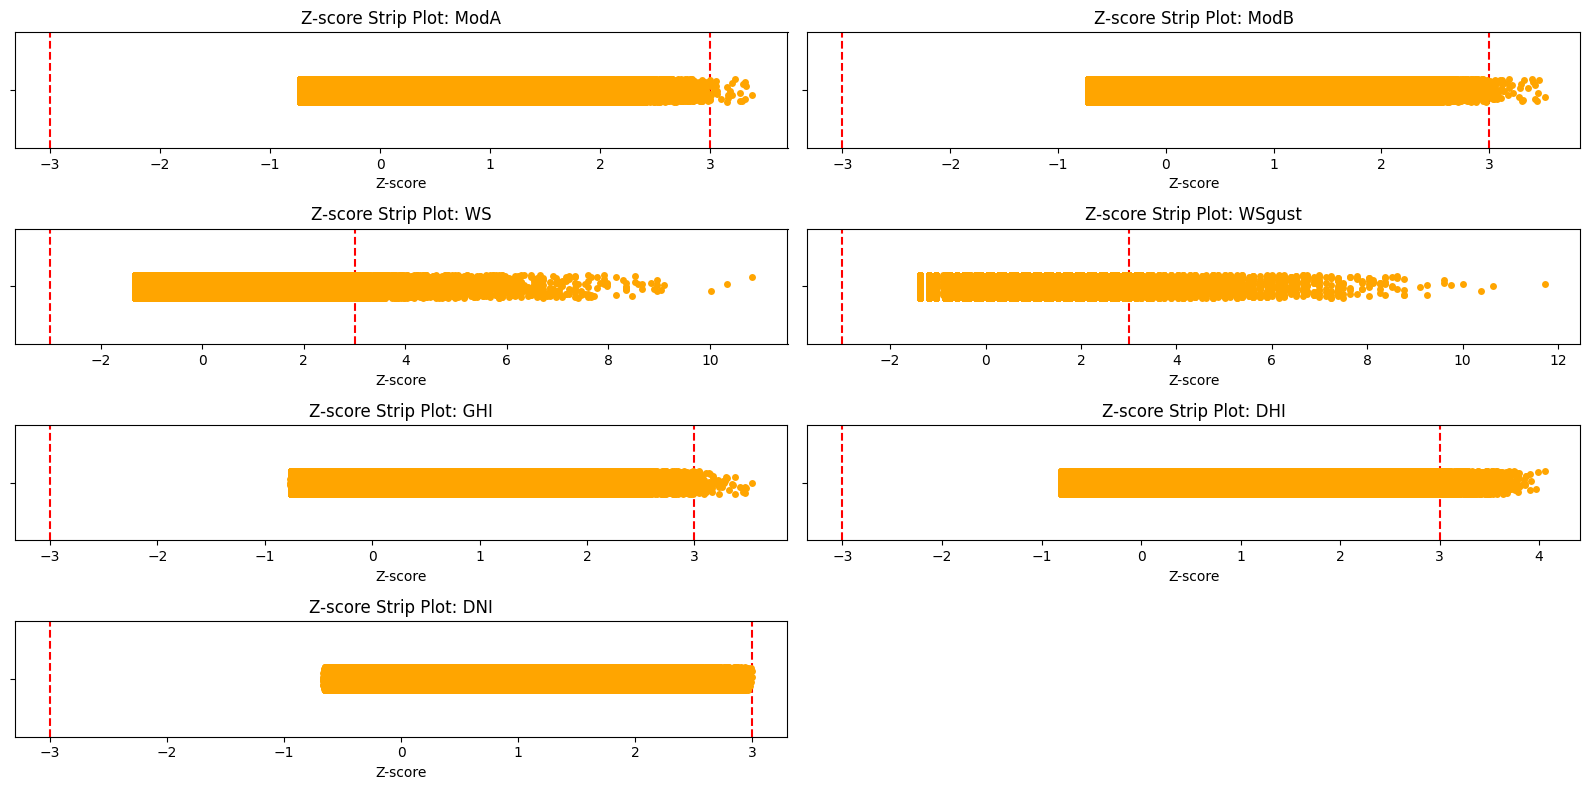

In [18]:
#Z-Score Outlier Strip Plot
n_cols = 2# adjust as needed
n_rows = (len(columns_to_check_for_outliers) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 2 * n_rows))
axes = axes.flatten()

for i, col in enumerate(columns_to_check_for_outliers):
    df['z'] = zscore(df[col].dropna())
    sns.stripplot(x='z', data=df.dropna(subset=[col]), color='orange', ax=axes[i])
    axes[i].axvline(3, color='red', linestyle='--')
    axes[i].axvline(-3, color='red', linestyle='--')
    axes[i].set_title(f'Z-score Strip Plot: {col}')
    axes[i].set_xlabel('Z-score')

# Remove unused axes if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


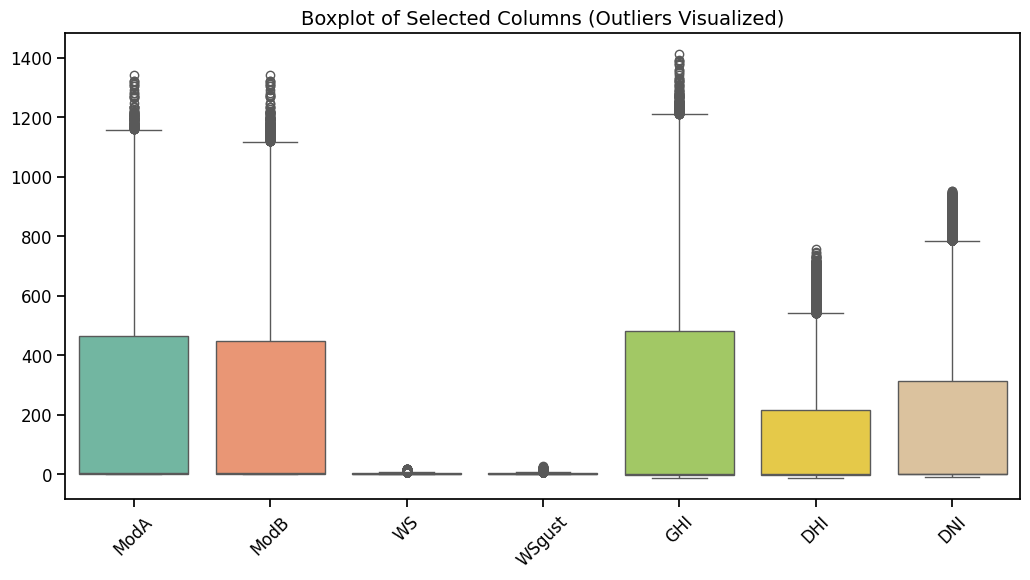

In [ ]:
#Visualizing outliers using boxplots
plt.figure(figsize=(max(8, num_cols * 1.5), 6))  # Auto-adjust width
sns.set_context("notebook", font_scale=1.1)

sns.boxplot(data=df[columns_to_check_for_outliers], palette="Set2")
plt.title("Boxplot of Selected Columns (Outliers Visualized)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


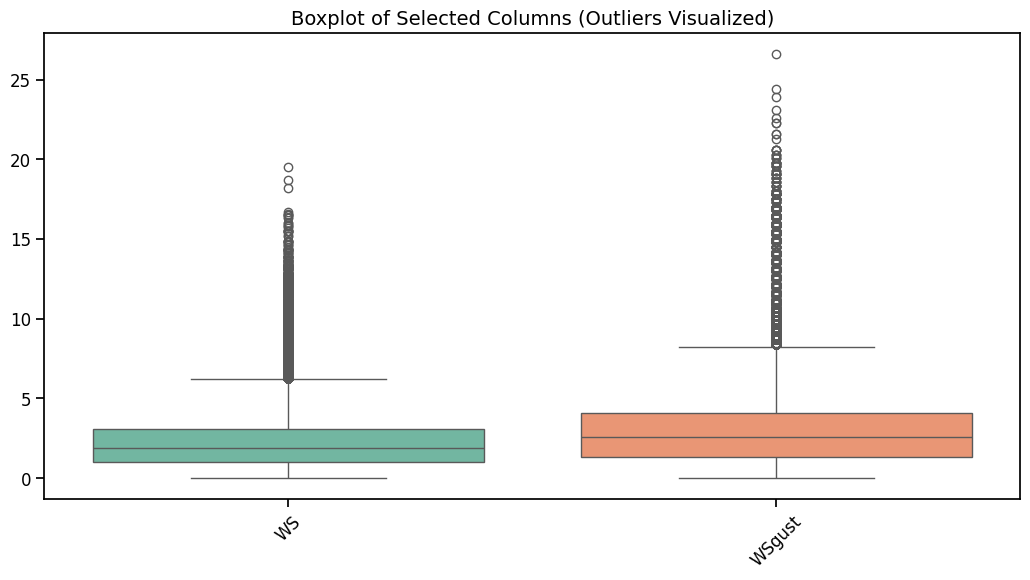

In [ ]:
#Singling out WS and WSgust
plt.figure(figsize=(max(8, num_cols * 1.5), 6))  # Auto-adjust width
sns.set_context("notebook", font_scale=1.1)

sns.boxplot(data=df[columns_to_check_for_outliers[2:4]], palette="Set2")
plt.title("Boxplot of Selected Columns (Outliers Visualized)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


## 🧹 5. Data Cleaning

#### Handle Missing Values

In [28]:
# only the Comments columns has a missing data and it has all of its data missing
columns_to_delete = ['Comments']
existing_columns = [col for col in columns_to_delete if col in df.columns]
df = df.drop(existing_columns, axis=1)

### Cleaning Impact

Not needed for this dataset

## 📈 6. Univariate Analysis (Single Variable)

## 📉 7. Bivariate/Multivariate Analysis

### Temperature Analysis

### Correlation & Relationship Analysis

### Bubble Chart

### Wind & Distribution Analysis

## 📅 9.  Time Series Trends 

### Time Series Analysis

## 🧠 10. Key Insights

## 🔚 11. Conclusion & Next Steps